In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
titan=pd.read_csv("train.csv")
titan_test=pd.read_csv("test.csv")
titan.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#things to be done:
#drop useless data(noise)
#scale the data
#find the best model
#create pipeline if needed
#evaluate on test set

In [4]:
#look for correlations
titan_corr=titan.corr()
titan_corr["Survived"].sort_values(ascending=True)

Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
PassengerId   -0.005007
Parch          0.081629
Fare           0.257307
Survived       1.000000
Name: Survived, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6349D56C8>,
      dtype=object)

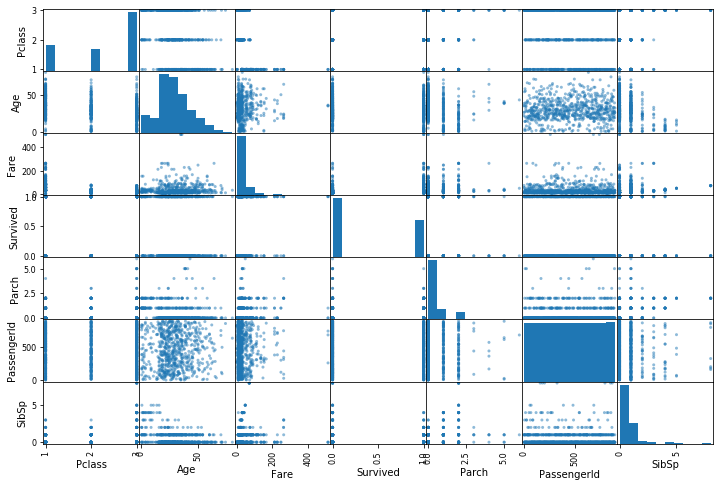

In [5]:
#use visuals to find any hidden correlation the numbers couldnt find
from pandas.plotting import scatter_matrix
atts=["Pclass","Age","Fare","Survived","Parch","PassengerId","SibSp"]
scatter_matrix(titan[atts],figsize=(12,8))

In [6]:
#no special correlations thus no need for stratified shuffle split
#though we already have our test set ready, lets still split the training set for more "diversified training"
from sklearn.model_selection import train_test_split
x_train,x_test=train_test_split(titan,test_size=0.2,random_state=369)
train_labels=x_train["Survived"]
test_labels=x_test["Survived"]
x_train.head()
x_test.drop("Survived",axis=1,inplace=True)

C:\Users\user\Anaconda4\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
#now lets clean the data
#name has nothing to do with survival, same as cabin(most which is null 
#copy the train set
train=x_train.copy()
train.drop("Name",axis=1,inplace=True)
#due to ticket containing a lot of strings in between it should be dropped
train.drop("Ticket",axis=1,inplace=True)
train.head()
#drop cabin also
train.drop("Cabin",axis=1,inplace=True)
train.head()
#replace the sex column with numbers where 1=male and 0=female
train.drop("Survived",axis=1,inplace=True)
train["Sex"]=train["Sex"].replace({"male":1,"female":0})
train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
57,58,3,1,28.5,0,0,7.2292,C
20,21,2,1,35.0,0,0,26.0000,S
107,108,3,1,NaN,0,0,7.7750,S
455,456,3,1,29.0,0,0,7.8958,C
657,658,3,0,32.0,1,1,15.5000,Q


In [20]:
#use onehotencoders to deal with the Embarked column
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#deal with the data and put the process in a pipeline
piper=Pipeline([
    ("imp",SimpleImputer(strategy="median"))
])
#no need to scale the data cus it will lead to distorted data


numerical=train.copy()
numerical["Embarked"]=numerical["Embarked"].replace({"C":1,"S":2,"Q":3})
numerical.head()
numeric=piper.fit_transform(numerical)
numerical=pd.DataFrame(numeric,columns=numerical.columns)

In [23]:

#mow lets bring in the models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
#using the free lunch theorem, no model is given special preference
from sklearn.model_selection import cross_val_score
Lreg=LinearRegression()
rig=Ridge(alpha=1,solver="cholesky")
elastic=ElasticNet(alpha=0.1,l1_ratio=0.5)
lassa=Lasso(alpha=0.1)
decision=DecisionTreeRegressor()
forest=RandomForestRegressor(n_estimators=10)
#now lets see the best score out there

#lets use a function here 
def cross_val(x):
    x.fit(numerical,train_labels)
    scorer=cross_val_score(x,numerical,train_labels,scoring="neg_mean_squared_error",cv=10)
    squit=np.sqrt(-scorer)
    print(x)
    return squit.mean()

In [24]:
#now lets see their scores
print(cross_val(Lreg))
print(cross_val(rig))
print(cross_val(elastic))
print(cross_val(lassa))
print(cross_val(decision))
print(cross_val(forest))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
0.37967990951215536
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='cholesky', tol=0.001)
0.37967964930048725
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
0.4108913515815894
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
0.45742936094285147
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,

In [10]:
#ridge is our best in this case though much can still be done if we tune hyperparameters
titan_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [25]:
#now we create a fuction that converts the test set to its "modelable" form
def optimizer(x):
    x.drop("Name",axis=1,inplace=True)
    x.drop("Ticket",axis=1,inplace=True)
    x.drop("Cabin",axis=1,inplace=True)
    x["Embarked"]=x["Embarked"].replace({"C":1,"S":2,"Q":3})
    x["Sex"]=x["Sex"].replace({"male":1,"female":0})
    return x
    

In [29]:
# now put the test set into the function and launch it into the model
#recall this isnt our real test set its the one we cut out of the train set

#i did this because the survived column isnt found in the test set.. U get?
output=optimizer(x_test)

KeyError: "['Name'] not found in axis"

In [30]:
from sklearn.metrics import accuracy_score
test_results=rig.predict(output)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [31]:
#lets try and 

[ 2.57315192e-01  1.02601577e-01  2.75012289e-01  9.34602354e-02
  6.41779558e-02  2.71949232e-01  5.56833067e-01  1.13739504e-01
  9.86520484e-02 -1.01379483e-01  7.04530839e-01  5.44334922e-01
  2.50283930e-01 -4.95324917e-02  6.16374152e-01  1.46596031e-01
  4.02581514e-01  1.00085019e+00  8.27272781e-02  5.89624528e-01
  2.81223633e-01  1.79327011e-01  2.75221149e-01  1.43596942e-01
  3.87962479e-02  5.58939725e-01  1.64676578e-01  2.09079296e-01
  9.27965678e-01  2.57019772e-01  1.77094837e-01  2.78383579e-01
  2.49408956e-01  2.51731709e-01  1.03208211e+00  5.13125446e-02
  3.53448848e-02  1.03417391e+00  8.18676877e-02  7.79534439e-01
  8.06149989e-01  8.65775633e-02  8.89057862e-02  7.61126985e-01
  5.92956921e-01  5.15664708e-01  1.19676374e-01  1.62447634e-01
  8.30240197e-02  1.76546011e-01  1.67449997e-02  3.72022365e-02
  5.86364959e-01  3.54845091e-01  1.02556650e-01  1.01456320e+00
  4.24682388e-01  5.55574673e-01  1.30295424e-01  4.57035244e-01
  3.08966257e-01 -3.63638